In [190]:
# learning using a CNN

# CNN for learning!

# learn the states of a double dot
import numpy as np
import tensorflow as tf
import glob
import os
import time

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

tf.logging.set_verbosity(tf.logging.INFO)

# application logic will be added here
def cnn_model_fn(features,labels,mode):
    '''Model function for CNN'''
    #input layer
    input_layer = tf.cast(tf.reshape(features,[-1,30,30,1]),tf.float32)
    
    conv1 = tf.layers.conv2d(inputs=input_layer,
                            filters=32,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2],strides=2)
    
    conv2 = tf.layers.conv2d(inputs=pool1,
                            filters=64,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],strides=2)
    
    flat = tf.contrib.layers.flatten(inputs=pool2)
    # dense output layer
    out1 = tf.layers.dense(inputs=flat,units=1024,activation=tf.nn.relu)  
    dropout1 = tf.layers.dropout(
      inputs=out1, rate=0.4, training=mode == learn.ModeKeys.TRAIN)
    
    out = tf.layers.dense(inputs=dropout1, units=4)
    
    loss = None
    train_op = None

    # Calculate loss( for both TRAIN AND EVAL modes)
    if mode != learn.ModeKeys.INFER:
        loss = tf.losses.mean_squared_error(out,labels['prob'])

    # Configure the training op (for TRAIN mode)
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.contrib.framework.get_global_step(),
            learning_rate=1e-3,
            optimizer=tf.train.AdamOptimizer)

    # Generate predictions
    predictions= {
        "prob" : out,
        "states" : tf.argmax(out,axis=1),
    }
    
    # Returna  ModelFnOps object
    return model_fn_lib.ModelFnOps(mode=mode,predictions=predictions,loss=loss, train_op=train_op)
    
def get_train_inputs():
    n_batch = 100
    index = np.random.choice(n_train,n_batch,replace=False)
    inp = []
    oup = []
    for i in index:
        dat = np.load(files[i])
        inp += [dat.item()['current_map']]
        oup += [dat.item()['label']]

    inp = np.array(inp,dtype=np.float32)
    oup = np.array(oup,dtype=np.float32)
    
    x = tf.constant(inp)
    y = tf.constant(oup)
    
    labels_dict = {}
    labels_dict['prob'] = y
    labels_dict['states'] = tf.argmax(y,axis=1)
    return x,labels_dict

def get_val_inputs():
    inp = []
    oup = []
       
    for file in files[n_train:(n_train + 100)]:
        dat = np.load(file)
        inp += [dat.item()['current_map']]
        oup += [dat.item()['label']]
    
    inp = np.array(inp,dtype=np.float32)
    oup = np.array(oup,dtype=np.float32)
    
    x = tf.constant(inp)
    y = tf.constant(oup)
    
    labels_dict = {}
    labels_dict['prob'] = y
    labels_dict['states'] = tf.argmax(y,axis=1)
    return x,labels_dict

def get_test_inputs():
    inp = []
    oup = []
       
    for file in files[n_train:]:
        dat = np.load(file)
        inp += [dat.item()['current_map']]
        oup += [dat.item()['label']]
    
    inp = np.array(inp,dtype=np.float32)
    oup = np.array(oup,dtype=np.float32)
    
    x = tf.constant(inp)
    y = tf.constant(oup)
    
    labels_dict = {}
    labels_dict['prob'] = y
    labels_dict['states'] = tf.argmax(y,axis=1)
    return x,labels_dict

# get the data
data_folder_path = "/Users/ssk4/Downloads/data_subimage/"
files = glob.glob(data_folder_path + "*.npy")

# shuffling the files to avoid any single dot bias
import random
random.shuffle(files)
files = files[:]

n_samples = len(files)
train_sample_ratio = 0.8
n_train = int(train_sample_ratio * n_samples)

print("Total number of samples :",n_samples)
print("Training samples :",n_train)
print("Test samples :",n_samples - n_train)

st = time.time()
# create the estimator
dd_classifier = learn.Estimator(model_fn=cnn_model_fn,model_dir="/tmp/cnn_prob/")

n_epochs = 10
steps_per_epoch = 100
for _ in range(n_epochs):
    dd_classifier.fit(
        input_fn=get_train_inputs,
        steps=steps_per_epoch)

    train_metrics = {
        "Train accuracy" : learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="states",label_key="states"),
    }
    dd_classifier.evaluate(input_fn=get_train_inputs,metrics=train_metrics,steps=1)

    val_metrics = {
        "Val accuracy" : learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="states",label_key="states"),
    }
    dd_classifier.evaluate(input_fn=get_val_inputs,metrics=val_metrics,steps=1)

metrics = {
    "accuracy" : learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="states",label_key="states"),
}
dd_classifier.evaluate(input_fn=get_test_inputs,metrics=metrics,steps=1)
print("Training done in",time.time()-st,"seconds.")




Total number of samples : 76700
Training samples : 61360
Test samples : 15340
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11953a630>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': None}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/cnn_prob/model.ckpt-1000
INFO:tensorflow:Saving checkpoints for 1001 into /tmp/cnn_prob/model.ckpt.
INFO:tensorflow:loss = 0.00263071, step = 1001
INFO:tensorflow:Saving checkpoints for 1100 into /tmp/cnn_prob/model.ckpt.
INFO

In [167]:

def accr_test_input_fn():
    inp = []
    oup = []
       
    for file in files[n_train:(n_train + 100)]:
        dat = np.load(file)
        inp += [dat.item()['current_map']]
        oup += [dat.item()['label']]
    
    inp = np.array(inp,dtype=np.float32)
    oup = np.array(oup,dtype=np.float32)
    
    x = tf.constant(inp)
    y = tf.constant(oup)
    return x,y

metrics = {
    "accuracy" : learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="states"),
}

pred = dd_classifier.predict(input_fn=accr_test_input_fn,as_iterable=False)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Restoring parameters from /var/folders/hs/nm7qn85519v78y5bbl49h61h001sq3/T/tmpnel54pgp/model.ckpt-5000


In [187]:
metrics = {
    "accuracy" : learn.MetricSpec(metric_fn=tf.metrics.accuracy, prediction_key="states",label_key="states"),
}
dd_classifier.evaluate(input_fn=get_train_inputs,metrics=metrics,steps=1)

INFO:tensorflow:Starting evaluation at 2017-07-01-17:55:59
INFO:tensorflow:Restoring parameters from /var/folders/hs/nm7qn85519v78y5bbl49h61h001sq3/T/tmp7me_3mgw/model.ckpt-100
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-07-01-17:56:00
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.93, global_step = 100, loss = 0.0134305


{'accuracy': 0.93000001, 'global_step': 100, 'loss': 0.013430518}

In [169]:
pred['states']

array([2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3,
       2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2,
       2, 2, 3, 2, 2, 2, 3, 3])

In [178]:
pred['prob']

array([[  1.53586641e-03,   5.17740846e-03,   9.50941443e-01,
          2.10614204e-02],
       [  1.37775205e-03,   3.36754322e-03,   9.73362803e-01,
          9.35178995e-03],
       [  5.08314930e-04,  -4.10084426e-03,   7.75267899e-01,
          2.43259087e-01],
       [  9.66005959e-04,  -1.75612420e-03,   6.38581038e-01,
          3.70760769e-01],
       [  4.98790294e-04,   2.79003754e-03,   1.00814617e+00,
         -4.23276424e-03],
       [  8.87231901e-04,   8.87972862e-03,   2.14482144e-01,
          7.55513906e-01],
       [  8.70760530e-04,  -5.79632074e-03,   6.50480747e-01,
          3.68960559e-01],
       [  4.69686463e-04,   6.43382221e-03,   9.58739400e-01,
          3.81074250e-02],
       [  5.87210059e-04,   2.56353058e-02,   1.01916778e+00,
         -2.43719220e-02],
       [  3.05661000e-04,   2.05680728e-04,   3.28062057e-01,
          6.84476078e-01],
       [  2.39092670e-03,   1.54843740e-02,   8.87747407e-01,
          5.56392074e-02],
       [  2.58115120e

In [152]:
out

array([], dtype=float64)

In [177]:
sess = tf.Session()
x,y = accr_test_input_fn()
st = tf.argmax(y,axis=1)
curr = sess.run(x)
out = sess.run(y)
print(out)

[[ 0.          0.          1.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.69222224  0.30777779]
 [ 0.          0.          0.50222224  0.49777779]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.18444444  0.81555557]
 [ 0.          0.          0.52888888  0.47111112]
 [ 0.          0.          0.94222224  0.05777778]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.24721603  0.75278395]
 [ 0.          0.          0.99333334  0.00666667]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.09111111  0.90888888]
 [ 0.          0.          0.61444443  0.38555557]
 [ 0.          0.36666667  0.63333333  0.        ]
 [ 0.01222222  0.10333333  0.88444442  0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.64333332  0.35666665]
 [ 0.          0.05555556  0.94

In [171]:
diff = out - pred['states']

In [173]:
list(diff).count(0)

94

In [121]:
# Testing of the experimental data loading
import numpy as np
import scipy.interpolate

data_folder_path = "/Users/ssk4/Downloads/exp_data/"
files = glob.glob(data_folder_path + "*.dat")

# Data format is V_LGD I_DC(nA) V_LGS I_AC(nA) t(sec)
# The format of the loaded array is [num_points,5]
index = np.random.randint(len(files))

for i in range(len(files)):

    dat = np.loadtxt(files[i])

    sub_size = 30
    grid_x = np.linspace(np.min(dat[:,0]),np.max(dat[:,0]),sub_size)
    grid_y = np.linspace(np.min(dat[:,2]),np.max(dat[:,2]),sub_size)
    xx,yy = np.meshgrid(grid_x,grid_y)
    interpolated_data = scipy.interpolate.griddata((dat[:,0],dat[:,2]),dat[:,1],(xx, yy), method='nearest')
    tf.logging.set_verbosity(tf.logging.ERROR)
    #import matplotlib.pyplot as plt
    #%matplotlib inline
    #plt.pcolor(interpolated_data)

    print(i,dd_classifier.predict(x=interpolated_data,as_iterable=False)['states'])

0 [2]
1 [3]
2 [3]
3 [3]
4 [3]
5 [3]
6 [3]
7 [2]
8 [2]
9 [3]
10 [3]
11 [2]
12 [3]
13 [3]
14 [3]
15 [2]
16 [3]
17 [3]
18 [3]
19 [3]
20 [3]
21 [3]
22 [3]
23 [3]
24 [3]
25 [3]
26 [3]
27 [3]
28 [3]
29 [3]
30 [3]
31 [3]
32 [3]
33 [3]
34 [3]
35 [3]
36 [2]
37 [2]
38 [2]
39 [3]
40 [3]
41 [3]
42 [3]
43 [3]
44 [3]
45 [3]
46 [2]
47 [2]
48 [2]
49 [2]
50 [3]
51 [2]
52 [3]
53 [3]


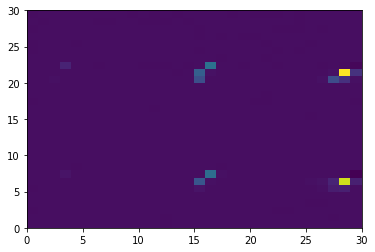

In [143]:
dat = np.loadtxt(files[53])

sub_size = 30
grid_x = np.linspace(np.min(dat[:,0]),np.max(dat[:,0]),sub_size)
grid_y = np.linspace(np.min(dat[:,2]),np.max(dat[:,2]),sub_size)
xx,yy = np.meshgrid(grid_x,grid_y)
interpolated_data = scipy.interpolate.griddata((dat[:,0],dat[:,2]),dat[:,1],(xx, yy), method='nearest')

import matplotlib.pyplot as plt
%matplotlib inline
plt.pcolor(interpolated_data)

In [115]:
interpolated_data

array([[ 0.0131284,  0.0130977,  0.0130165,  0.0130461,  0.0130579,
         0.0130705,  0.0130673,  0.013014 ,  0.013067 ,  0.0130673,
         0.0130742,  0.0130424,  0.0131063,  0.013041 ,  0.0130354,
         0.0130415,  0.0130442,  0.0129011,  0.0129984,  0.0130359,
         0.0130761,  0.0130623,  0.0130196,  0.0130593,  0.0130596,
         0.0130447,  0.013058 ,  0.0130686,  0.0130626,  0.0130784],
       [ 0.0130309,  0.0130342,  0.0130773,  0.013095 ,  0.0130655,
         0.0130709,  0.0130834,  0.0130363,  0.0130766,  0.0130537,
         0.012883 ,  0.0130093,  0.0130959,  0.0130351,  0.0130685,
         0.0130667,  0.0130831,  0.0129268,  0.0130313,  0.0130226,
         0.01302  ,  0.0130421,  0.0130307,  0.0130727,  0.0130674,
         0.013017 ,  0.013053 ,  0.0130509,  0.0130441,  0.0130853],
       [ 0.0130076,  0.0130482,  0.0130506,  0.0130161,  0.0130545,
         0.0130134,  0.0130176,  0.0130303,  0.0130606,  0.0130398,
         0.0130371,  0.0130427,  0.0130241,  0

In [175]:
dd_classifier.export_savedmodel('/tmp/dd_classifier',serving_input_fn=)

TypeError: export_savedmodel() missing 1 required positional argument: 'serving_input_fn'